In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

import lightgbm as lgb

In [3]:
df = pd.read_csv("data3.csv")
df["dernierRapportDirect_rapport"]

C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (95,96,98) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


0        169.0
1          6.9
2         38.0
3         22.0
4          5.8
         ...  
32687     16.0
32688    190.0
32689      4.4
32690      8.9
32691      9.8
Name: dernierRapportDirect_rapport, Length: 32692, dtype: float64

In [11]:
features = ['num',
 'classement',
 'id',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'avisTrainer',
 'nbArrivé',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'jumentPleine',
 'handicapDistance',
 'gainsParticipant_gainsVictoires',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportDirect_rapport',
 'dernierRapportReference_rapport',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple',
 'nonPartant']

In [12]:
df_train = df[features]
df_train["classement"].replace(['DA', 'D1', 'A ',
       'D7', 'D8', 'H8', 'T ', 'G ', 'D5', 'D6', 'D', 'D3', 'D4', 'D2', 'D ',
       'G5', 'D9', 'H9', 'G4'], 10, inplace=True)

df_train.apply(pd.to_numeric, errors='ignore')

C:\Users\raves\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,num,classement,id,tpsLastRace,last_race_dist,fer,firstTimeFer,sex,age_x,dist,...,gainsParticipant_gainsAnneeEnCours,gainsParticipant_gainsAnneePrecedente,dernierRapportDirect_rapport,dernierRapportReference_rapport,nbCourseCouple,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple,nonPartant
0,1,9,2017010175002,37,2100,0,False,0,4,2700,...,3418000.0,485000.0,169.0,110.0,16,1,1,1,18,False
1,2,10,2017010175002,24,2850,0,False,0,4,2700,...,4000000.0,0.0,6.9,6.6,5,3,1,0,80,False
2,3,8,2017010175002,17,2700,2,False,0,4,2700,...,4092000.0,250000.0,38.0,34.0,5,1,0,0,20,False
3,4,3,2017010175002,27,2700,2,False,1,4,2700,...,4377000.0,0.0,22.0,19.0,1,0,0,1,100,False
4,5,5,2017010175002,17,2700,3,False,0,4,2700,...,3857000.0,547000.0,5.8,7.0,1,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32687,12,5,2018063075026,13,2550,0,False,0,4,2875,...,30000.0,3022000.0,16.0,19.0,1,0,0,0,0,False
32688,13,0,2018063075026,26,2200,0,False,1,4,2875,...,280000.0,2774000.0,190.0,94.0,3,0,0,0,0,False
32689,14,10,2018063075026,25,2700,3,False,1,4,2875,...,1800000.0,1290000.0,4.4,6.4,5,1,0,0,20,False
32690,15,1,2018063075026,18,2150,3,False,1,4,2875,...,1128000.0,1980000.0,8.9,10.0,3,2,0,0,66,False


In [21]:
gss = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(df_train, groups=df_train['id'])

X_train_inds, X_test_inds = next(gss)

train_data= df_train.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['id','classement'])]
y_train = train_data.loc[:, train_data.columns.isin(['classement'])]

groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()

test_data = df_train.iloc[X_test_inds]

#We need to keep the id for later predictions
X_test = test_data.loc[:, ~test_data.columns.isin(['id','classement'])]
y_test = test_data.loc[:, test_data.columns.isin(['classement'])]

test_groups = test_data.groupby('id').size().to_frame('size')['size'].to_numpy()

In [15]:
train_data = lgb.Dataset(X_train, 
                         label=y_train, 
                         categorical_feature=['oeilleres'], 
                         free_raw_data=False,
                         group=groups)
test_data = lgb.Dataset(X_test, 
                        label=y_test, 
                        categorical_feature=['oeilleres'],
                        free_raw_data=False,
                         group=groups)

In [22]:
train_data

,num,classement,id,tpsLastRace,last_race_dist,fer,firstTimeFer,sex,age_x,dist,...,gainsParticipant_gainsAnneeEnCours,gainsParticipant_gainsAnneePrecedente,dernierRapportDirect_rapport,dernierRapportReference_rapport,nbCourseCouple,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple,nonPartant
0,1,9,2017010175002,37,2100,0,False,0,4,2700,...,3418000.0,485000.0,169.0,110.0,16,1,1,1,18,False
1,2,10,2017010175002,24,2850,0,False,0,4,2700,...,4000000.0,0.0,6.9,6.6,5,3,1,0,80,False
2,3,8,2017010175002,17,2700,2,False,0,4,2700,...,4092000.0,250000.0,38.0,34.0,5,1,0,0,20,False
3,4,3,2017010175002,27,2700,2,False,1,4,2700,...,4377000.0,0.0,22.0,19.0,1,0,0,1,100,False
4,5,5,2017010175002,17,2700,3,False,0,4,2700,...,3857000.0,547000.0,5.8,7.0,1,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32671,12,2,2018063075024,22,2850,3,False,1,8,2150,...,2109500.0,10740000.0,7.9,8.7,4,0,1,1,50,False
32672,13,6,2018063075024,6,2725,3,False,1,8,2150,...,2965000.0,5253000.0,23.0,24.0,6,1,1,1,50,False
32673,14,10,2018063075024,16,2775,0,False,0,9,2150,...,176000.0,2575000.0,134.0,96.0,17,1,0,0,5,False
32674,15,7,2018063075024,48,3050,3,False,1,9,2150,...,0.0,6527000.0,64.0,46.0,1,0,0,0,0,False


In [23]:
gbm = lgb.LGBMRanker()

In [24]:
gbm.fit(X_train, y_train.astype(np.int32), group=groups)

LGBMRanker()

In [25]:
predictions = gbm.predict(X_test)

In [26]:
test_data["rank_pred"] = predictions
test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("first").astype(int)

<ipython-input-26-a735eefbe0a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = predictions
<ipython-input-26-a735eefbe0a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-26-a735eefbe0a1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [27]:
test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == "1"]["dernierRapportDirect_rapport"].mean()

9.137154150197631

In [28]:
len(test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == "1"]) / len(test_data.groupby("id"))

0.3119565217391304

In [55]:
def kelly(cote, capital):
    return (cote*0.3-0.7)/cote

In [56]:
argent = 100
evo = [100]
for name,group in test_data.groupby("id"):
    cote = group.loc[group["rank_pred"] == 1]["dernierRapportDirect_rapport"].values[0]
    
    if not np.isnan(cote):
        f_kelly = kelly(cote, argent)
        if group.loc[group["rank_pred"] == 1]["classement"].values[0] == "1":
            argent += cote * f_kelly*100
        else:
            argent -= f_kelly*100
    evo += [argent]

In [57]:
argent

40705.93059316305

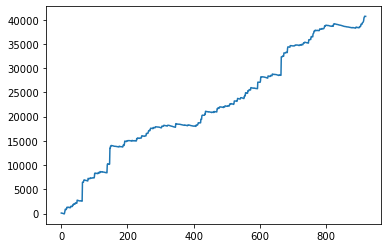

In [58]:
plt.plot(evo)

In [34]:
y_test

,classement
36,3
37,2
38,4
39,6
40,10
...,...
32687,5
32688,0
32689,10
32690,1


In [59]:
list(X_test)

35

In [137]:
features_pred = ['num',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'avisTrainer',
 'nbArrivé',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'jumentPleine',
 'handicapDistance',
 'gainsParticipant_gainsVictoires',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportDirect_rapport',
 'dernierRapportReference_rapport',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple',
 'nonPartant']

In [145]:
today = pd.read_csv("today.csv", index_col=0)
today_feat = today[features_pred]
today_feat

,num,tpsLastRace,last_race_dist,fer,firstTimeFer,sex,age_x,dist,avisTrainer,nbArrivé,...,gainsParticipant_gainsAnneeEnCours,gainsParticipant_gainsAnneePrecedente,dernierRapportDirect_rapport,dernierRapportReference_rapport,nbCourseCouple,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple,nonPartant
0,1,186,2675,0,False,1,5,2700,3,11,...,720000.0,943200.0,37.0,36.0,6,1,0,0,16,False
1,2,37,2700,6,False,1,5,2700,2,12,...,691000.0,2149000.0,131.0,124.0,9,0,0,0,0,False
2,3,18,2800,3,False,1,5,2700,2,9,...,1210500.0,960000.0,15.0,15.0,0,0,0,0,0,False
3,4,25,3000,6,False,1,5,2700,2,11,...,369000.0,2250000.0,30.0,32.0,0,0,0,0,0,False
4,5,28,2000,3,False,1,5,2700,2,11,...,415000.0,2284000.0,41.0,42.0,6,0,1,0,16,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,12,20,3025,3,False,1,5,2775,1,11,...,4509000.0,806000.0,4.8,7.4,5,1,1,1,60,False
12,13,23,2850,0,False,1,6,2775,3,12,...,5074000.0,2556000.0,59.0,51.0,0,0,0,0,0,False
13,14,10,2725,3,False,1,7,2775,2,11,...,2969000.0,4165000.0,23.0,25.0,1,0,0,1,100,False
14,15,29,3025,0,False,1,5,2775,2,12,...,4214000.0,2330000.0,7.0,6.1,3,1,0,0,33,False


In [151]:
list(today)

['num',
 'nom',
 'id',
 'date',
 'url',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'driver_x',
 'trainer',
 'avisTrainer',
 'music',
 'nbArrivé',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'numPmu',
 'age_y',
 'sexe',
 'race',
 'statut',
 'oeilleres',
 'proprietaire',
 'entraineur',
 'driver_y',
 'driverChange',
 'indicateurInedit',
 'musique',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'nomPere',
 'nomMere',
 'jumentPleine',
 'engagement',
 'supplement',
 'handicapDistance',
 'poidsConditionMonteChange',
 'urlCasaque',
 'eleveur',
 'allure',
 'avisEntraineur',
 'robe_code',
 'robe_libelleCourt',
 'robe_libelleLong',
 'gainsParticipant_gainsCarriere',
 'gainsParticipant_gainsVictoires',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportDirect_typePari',
 'dernierRappor

In [147]:
pred_today = gbm.predict(today_feat)

In [148]:
today["pred"] = pred_today
today['pred'] = today.groupby("id")["pred"].rank("dense",ascending=True).astype(int)
today['pred'] = today.groupby("id")["pred"].rank("first").astype(int)

In [155]:
groupe_len = today[["num", "nom","pred","id","url"]].groupby("id").size()

In [ ]:
def get_course_num(pred, n):
    groupe_len = pred[["num", "nom","pred","id","url"]].groupby("id").size()
    
    return pred.iloc[]

today[["num", "nom","pred","id","url"]].groupby("id").size()

In [157]:
winners = today[["num", "nom","pred","id","url"]].groupby("id")["pred"].min()

id
2022111102025    16
2022111102026    14
2022111102027    13
2022111102028    16
2022111130018    16
2022111144045    16
2022111144046    18
2022111144047    14
2022111144048    14
2022111149017    13
2022111150084    12
2022111150085    12
2022111150086    16
2022111150087    13
2022111150088    12
2022111150089    12
2022111169021    13
2022111169022    10
2022111169023    13
2022111169024    16
2022111169025    16
2022111169028     9
Name: pred, dtype: int32

In [160]:
today.loc[today["pred"] == 1]

,num,nom,id,date,url,tpsLastRace,last_race_dist,fer,firstTimeFer,sex,...,nbCourseCouple,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple,nonPartant,ecurie,tauxReclamation,placeCorde,pred
11,12,HISTORY SIXTY ONE,2022111169021,2022-11-11,https://www.letrot.com/stats/fiche-cheval/hist...,24,2675,3,False,1,...,9,3,1,3,77,False,NaN,NaN,NaN,1
6,7,EPISTOLAIRE,2022111169022,2022-11-11,https://www.letrot.com/stats/fiche-cheval/epis...,28,2850,3,False,1,...,0,0,0,0,0,False,NaN,NaN,NaN,1
9,10,HAMPTONS,2022111169023,2022-11-11,https://www.letrot.com/stats/fiche-cheval/hamp...,27,2725,6,False,0,...,1,1,0,0,100,False,NaN,NaN,NaN,1
12,13,IN THE AIR DELO,2022111169024,2022-11-11,https://www.letrot.com/stats/fiche-cheval/in-t...,12,2600,0,False,0,...,7,0,0,2,28,False,NaN,NaN,NaN,1
8,9,IRA STAR,2022111169025,2022-11-11,https://www.letrot.com/stats/fiche-cheval/ira-...,54,2850,0,False,1,...,12,1,0,4,41,False,NaN,NaN,NaN,1
5,6,EXPRESSO,2022111169028,2022-11-11,https://www.letrot.com/stats/fiche-cheval/expr...,12,2600,1,False,1,...,1,0,0,1,100,False,NaN,NaN,NaN,1
6,7,INDIGO DE BANVILLE,2022111149017,2022-11-11,https://www.letrot.com/stats/fiche-cheval/indi...,12,2400,0,False,1,...,8,1,1,0,25,False,NaN,NaN,NaN,1
12,13,ERISTOFF GOLD,2022111144045,2022-11-11,https://www.letrot.com/stats/fiche-cheval/eris...,26,2700,0,False,1,...,6,0,1,2,50,False,NaN,600000.0,NaN,1
15,16,ENDURO,2022111144046,2022-11-11,https://www.letrot.com/stats/fiche-cheval/endu...,12,2000,3,False,1,...,2,1,1,0,100,False,NaN,NaN,NaN,1
8,9,ILOWA D'OHARA,2022111144047,2022-11-11,https://www.letrot.com/stats/fiche-cheval/ilow...,34,2850,0,False,1,...,11,0,3,2,45,False,NaN,NaN,NaN,1
